In [1]:
import os
from pathlib import Path
from operator import itemgetter
import pickle
import pydicom
from time import time
import pandas

import matplotlib.pyplot as plt
import numpy as np

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.CATCH_utils import *
from LazyLuna.Tables  import *
from LazyLuna.Figures import *

In [2]:
# basepaths
bp        = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases'
bp_annos1 = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/JGold'
bp_annos2 = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/FCN'
bp_cases  = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Cases'
bp_imgs   = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Imgs'

In [ ]:
# get the paths of imgs and annotations via SeriesInstanceUIDs
imgsanno_paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)

print('Nr of path tuples: ', len(imgsanno_paths))
case_names = sorted([c[0] for c in imgsanno_paths])
from pprint import pprint
print('Existing Annotations: ', len(sorted([c[0] for c in imgsanno_paths if os.path.exists(c[1])])))
pprint(sorted([c[0] for c in imgsanno_paths if os.path.exists(c[1])]))

cases = []
sax_cine_view = SAX_CINE_View()
sax_cs_view   = SAX_CS_View()
for count, (imgp,annop) in enumerate(imgsanno_paths):
    print(count)
    print(os.path.basename(imgp), os.path.basename(annop))
    st = time()
    case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos))
    case = sax_cine_view.initialize_case(case)
    case = sax_cs_view  .initialize_case(case)
    case.store(bp_cases)
    cases.append(case)
    print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)
    print()

,case,reader1,reader2,LVESV Gold,LVESV FCN,LVESV difference,LVEDV Gold,LVEDV FCN,LVEDV difference,RVESV Gold,...,LVSV avg,LVEF avg,RVSV avg,RVEF avg,LVMYOMASS avg,RVMYOMASS avg,LVESP avg,RVESP avg,LVEDP avg,RVEDP avg
0,ECSPRESS-003,Gold,FCN,44.669443,47.482644,-2.813201,142.076853,143.149878,-1.073025,78.063904,...,96.537321,67.694890,83.269657,56.782826,89.674892,0.0,10.0,11.0,20.0,12.0
1,ECSPRESS-012,Gold,FCN,78.548260,79.056786,-0.508526,157.611798,157.845671,-0.233873,76.381420,...,78.926212,50.039301,73.594788,50.989103,114.650046,0.0,7.5,8.0,20.0,24.0
2,ECSPRESS-056,Gold,FCN,135.394122,128.986198,6.407924,244.766395,237.912382,6.854013,86.953921,...,109.149229,45.234255,93.177158,52.021954,106.906640,0.0,9.0,9.5,20.5,12.0


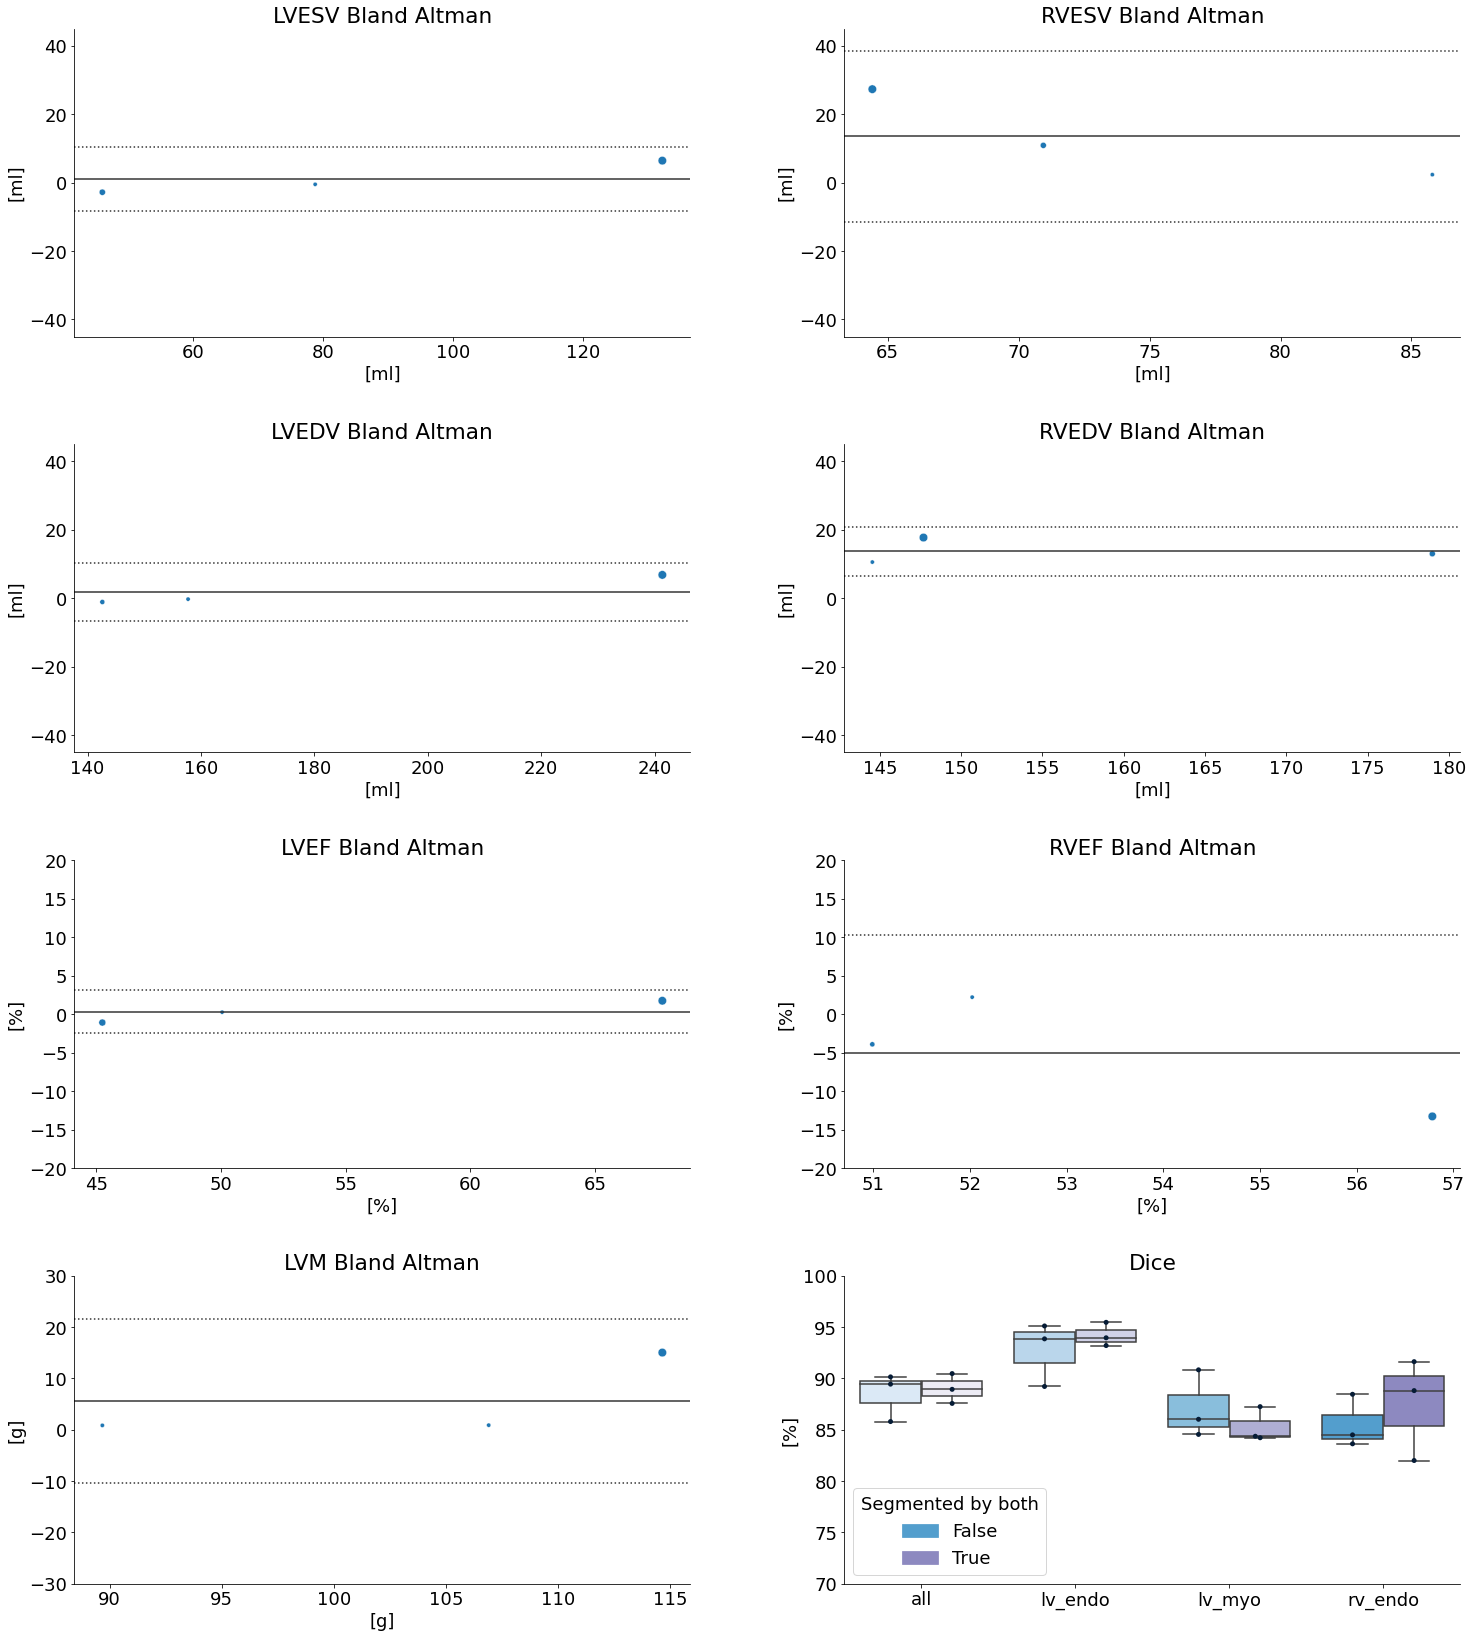

In [3]:
cases  = [pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in os.listdir(bp_cases)]
cases1 = sorted([c for c in cases if c.reader_name=='Gold'], key=lambda c: c.case_name)
cases2 = sorted([c for c in cases if c.reader_name=='FCN'],  key=lambda c: c.case_name)

sax_cine_view = SAX_CINE_View()
sax_cs_view   = SAX_CS_View()

ccs = [Case_Comparison(sax_cs_view.customize_case(c1), sax_cs_view.customize_case(c2)) for c1,c2 in zip(cases1,cases2)]
table = CC_ClinicalResultsTable()
table.calculate(ccs, True)
table.add_bland_altman_dataframe(ccs)
display(table.df)

SAX_BlandAltman_plot(ccs, '/Users/dietrichhadler/Desktop')
#SAX_candlelight_plot(ccs, '/Users/dietrichhadler/Desktop')

In [ ]:
view = SAX_CINE_View()
case = view.customize_case(case)
print(case.case_name)

print(case.type)
print(case.categories)
print(case.other_categories)
print(case.all_imgs_sop2filepath.keys())
for k in case.all_imgs_sop2filepath.keys():
    print(k, len(case.all_imgs_sop2filepath[k]), end=', ')
for cr in case.crs:
    print(cr.name, cr.get_cr(), end=', ')